<a href="https://colab.research.google.com/github/adithyabalakumar/EVA-4/blob/master/S6/With_L1_and_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [44]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/S6/With L1 and L2/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/S6/With L1 and L2


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [48]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 24

       # self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 22

        # TRANSITION BLOCK 1
        
        self.convblock4 = nn.Sequential(
            nn.MaxPool2d(2, 2) ,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         )  #output_size = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 7

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 3
         
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [50]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             576
      BatchNorm2d-10            [-1, 8, 22, 22]              16
          Dropout-11            [-1, 8, 22, 22]               0
             ReLU-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)


    #L1 loss
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        reg_loss += l1_crit(param,zero_vector)

    factor = 0.0005
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [52]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.31584614515304565 Batch_id=468 Accuracy=90.72: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9844/10000 (98.44%)

EPOCH: 1


Loss=0.21482926607131958 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.23977437615394592 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.23386265337467194 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.19662366807460785 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0644, Accuracy: 9810/10000 (98.10%)

EPOCH: 5


Loss=0.171950563788414 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9831/10000 (98.31%)

EPOCH: 6


Loss=0.1585056036710739 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.20032763481140137 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9855/10000 (98.55%)

EPOCH: 8


Loss=0.1771504431962967 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.2005079984664917 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9881/10000 (98.81%)

EPOCH: 10


Loss=0.16837181150913239 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9872/10000 (98.72%)

EPOCH: 11


Loss=0.1646655946969986 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9874/10000 (98.74%)

EPOCH: 12


Loss=0.169126495718956 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.19178920984268188 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9840/10000 (98.40%)

EPOCH: 14


Loss=0.1570776402950287 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9829/10000 (98.29%)

EPOCH: 15


Loss=0.1343621462583542 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9891/10000 (98.91%)

EPOCH: 16


Loss=0.15955273807048798 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9862/10000 (98.62%)

EPOCH: 17


Loss=0.21813946962356567 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9876/10000 (98.76%)

EPOCH: 18


Loss=0.1435699462890625 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9822/10000 (98.22%)

EPOCH: 19


Loss=0.16350321471691132 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9891/10000 (98.91%)

EPOCH: 20


Loss=0.2046210914850235 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9905/10000 (99.05%)

EPOCH: 21


Loss=0.18148721754550934 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9871/10000 (98.71%)

EPOCH: 22


Loss=0.24736011028289795 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 38.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9810/10000 (98.10%)

EPOCH: 23


Loss=0.15118902921676636 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0754, Accuracy: 9774/10000 (97.74%)

EPOCH: 24


Loss=0.16300977766513824 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9898/10000 (98.98%)

EPOCH: 25


Loss=0.17703062295913696 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9849/10000 (98.49%)

EPOCH: 26


Loss=0.12976482510566711 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9878/10000 (98.78%)

EPOCH: 27


Loss=0.18023118376731873 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0798, Accuracy: 9768/10000 (97.68%)

EPOCH: 28


Loss=0.19271054863929749 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9775/10000 (97.75%)

EPOCH: 29


Loss=0.15796896815299988 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9841/10000 (98.41%)

EPOCH: 30


Loss=0.18010693788528442 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9882/10000 (98.82%)

EPOCH: 31


Loss=0.15906783938407898 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9846/10000 (98.46%)

EPOCH: 32


Loss=0.20525801181793213 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9894/10000 (98.94%)

EPOCH: 33


Loss=0.21414119005203247 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9905/10000 (99.05%)

EPOCH: 34


Loss=0.19529002904891968 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9875/10000 (98.75%)

EPOCH: 35


Loss=0.15389364957809448 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9815/10000 (98.15%)

EPOCH: 36


Loss=0.14539286494255066 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9895/10000 (98.95%)

EPOCH: 37


Loss=0.15985798835754395 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9866/10000 (98.66%)

EPOCH: 38


Loss=0.18033447861671448 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9876/10000 (98.76%)

EPOCH: 39


Loss=0.13652591407299042 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]



Test set: Average loss: 0.0695, Accuracy: 9805/10000 (98.05%)



In [53]:
import pickle

pickle_file_path = "/content/gdrive/My Drive/Colab Notebooks/S6/With L1 and L2/with L1 and L2.pickle"
pickle_obj = {"test_accuracy": test_acc, "test_loss": test_losses}

with open(pickle_file_path, 'wb') as f:
  pickle.dump(pickle_obj, f)
  print("Test accuracy and loss write completed!")

Test accuracy and loss write completed!


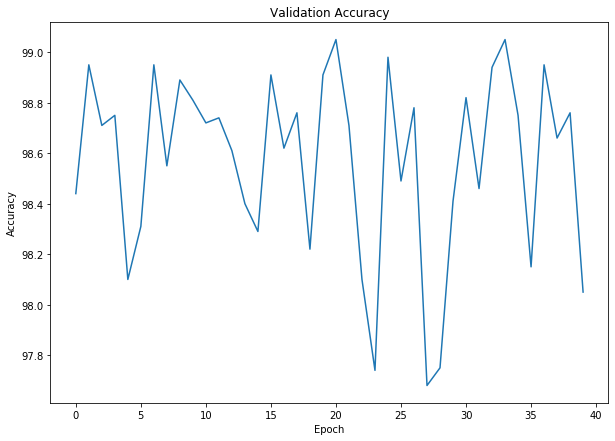

In [54]:
import matplotlib.pyplot as plt

val_acc_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test accuracy plot
axs.plot(test_acc)
axs.set_title("Validation Accuracy")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
val_acc_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/With L1 and L2/validation_accuracy.jpg')

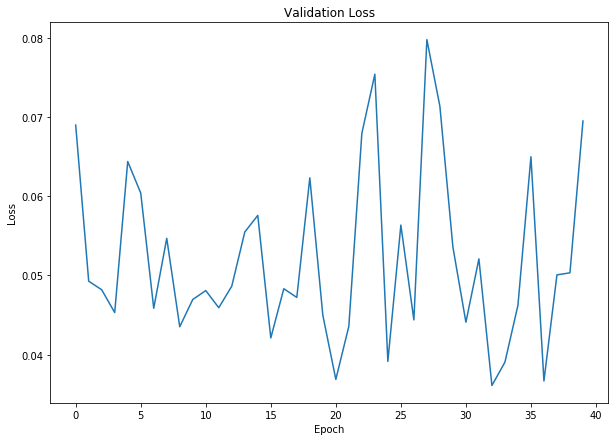

In [55]:
val_loss_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test loss plot
axs.plot(test_losses)
axs.set_title("Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
val_loss_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/With L1 and L2/validation_loss.jpg')

**Misclassified** **Images**

In [0]:
import numpy as np

from google.colab import files

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count == 25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig("/content/gdrive/My Drive/Colab Notebooks/S6/With L1 and L2/Misclassified Images/image_" + str(count)+".jpg")
                plt.close(fig)
                count += 1